# Bike Sharing Demand(자전거 수요 예측 조사)
: 도시에 있는 임대 자전거의 수요 예측
    http://www.kaggle.com/c/bike-sharing-demand

# EDA(탐색적 데이터 분석)

In [72]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats    # 확률 분포
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 그래프에 격자 그리기
plt.style.use('ggplot')

# 한글 폰트 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

In [73]:
# train data 불러오기
train = pd.read_csv('./Data/bike_train.csv', parse_dates=['datetime'])   # datetime 컬럼을 날짜화 시킴
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data field
datetime - hourly date + timestamp     
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter      
holiday - whether the day is considered a holiday    
workingday - whether the day is neither a weekend nor holiday     
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy     
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist    
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog       
temp - temperature in Celsius     
atemp - "feels like" temperature in Celsius     
humidity - relative humidity    
windspeed - wind speed     
casual - number of non-registered user rentals initiated     
registered - number of registered user rentals initiated     
count - number of total rentals    

> 상기 casual, registered, count는 temp data(검증 데이터)에는 존재하지 않으므로 feature로 사용할 수 없음    
> 모델의 측정은 RMSLE(Root Mean Squared Logarithmic Error) 방법을 사용   
> 머신러닝 작업 중 분류(Classification)와 회귀(Regression) 중 자전거 대여량을 예측하는 문제이므로 회귀(Regression)를 사용한다.

In [74]:
# train data의 Dimension 확인
train.shape

(10886, 12)

In [75]:
# train data의 컬럼 이름 확잉ㄴ
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [76]:
# train data의 컬럼 형태 확인
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [77]:
# train data의 컬럼 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [78]:
# train data의 temp column의 기본 통계량
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [79]:
# train의 기본통계량
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [80]:
# train data의 결측치 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [81]:
# missingno
# !pip install missingno

<AxesSubplot:>

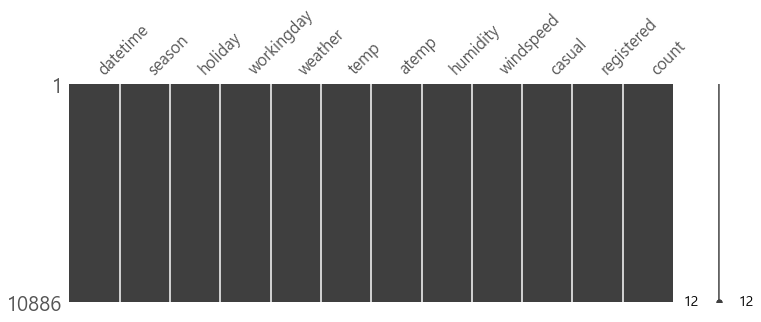

In [82]:
# null 여부를 chart로 확인
import missingno as msno
msno.matrix(train, figsize=(12,4))

In [83]:
# datetime을 분할하여 추가
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

In [84]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


In [85]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

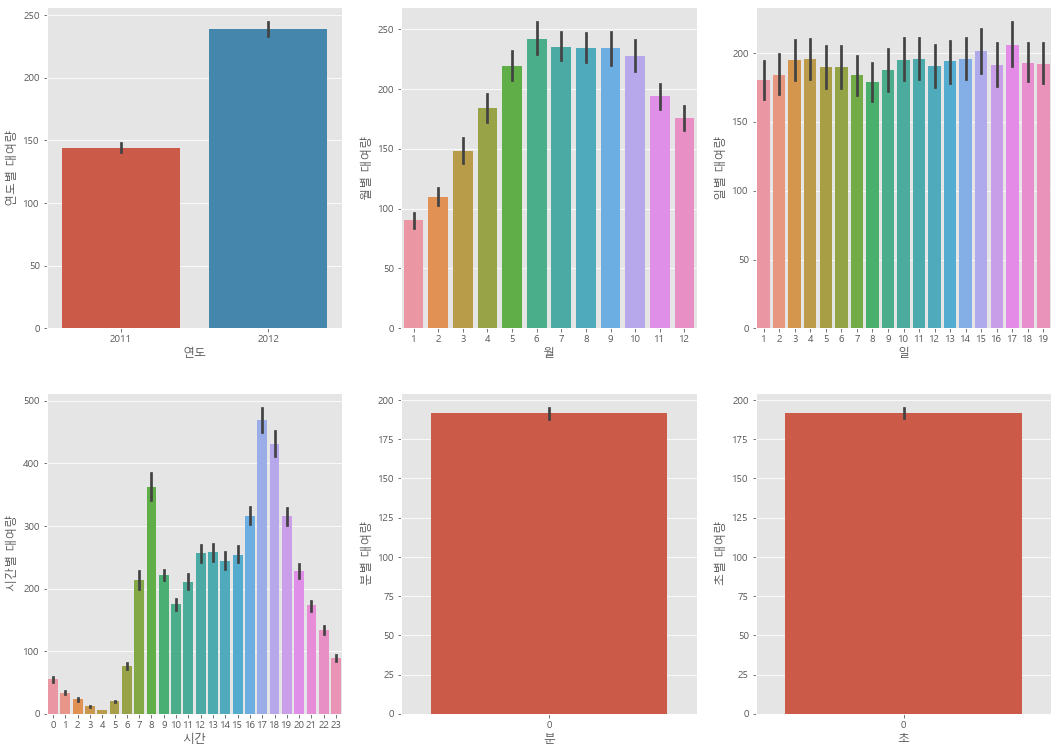

In [86]:
# 막대 그래프로 연도, 월, 일, 시간, 분, 초에 대한 그래프 확인하기
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,13)

sns.barplot(data=train, x='year', y='count', ax=ax1)
ax1.set(xlabel='연도', ylabel='연도별 대여량')

sns.barplot(data=train, x='month', y='count', ax=ax2)
ax2.set(xlabel='월', ylabel='월별 대여량')

sns.barplot(data=train, x='day', y='count', ax=ax3)
ax3.set(xlabel='일', ylabel='일별 대여량')

sns.barplot(data=train, x='hour', y='count', ax=ax4)
ax4.set(xlabel='시간', ylabel='시간별 대여량')

sns.barplot(data=train, x='minute', y='count', ax=ax5)
ax5.set(xlabel='분', ylabel='분별 대여량')

sns.barplot(data=train, x='second', y='count', ax=ax6)
ax6.set(xlabel='초', ylabel='초별 대여량')

plt.show()

- 연도별 대여량은 2011년 보다 2012년이 더 많다.   
- 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.   
- 일별 대여량은 1월부터 19일까지 있고 나머지 일자는 test.csv 에 있으므로 feature로 사용할 수 없다.   
- 시간별 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 평일로 구분해 볼 필요가 있다.    
- 분, 초는 다 0이기 때문에 의미가 없다.

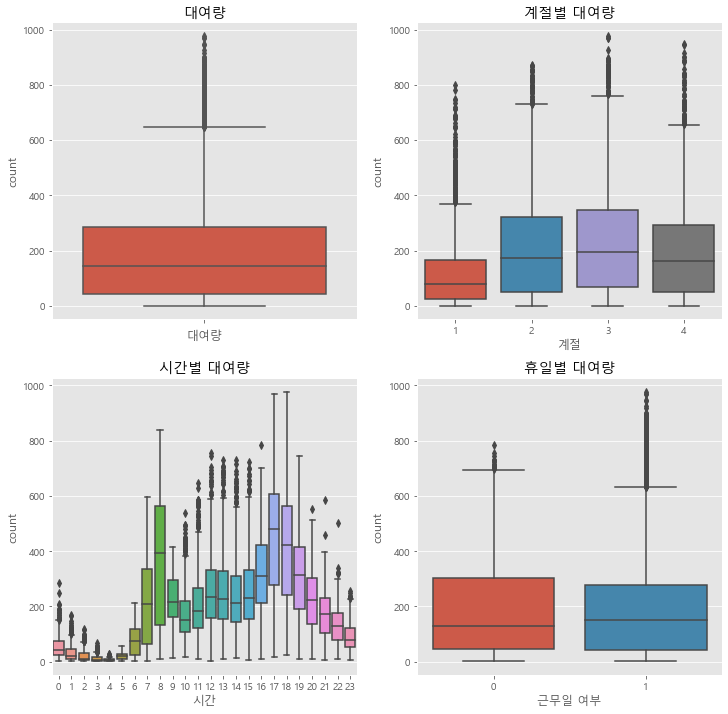

In [87]:
# boxplot으로 대여량, 계절별 대여량, 시간별 대여량
figure, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12,12)

sns.boxplot(data=train, y = 'count', orient= 'v', ax=ax1)
ax1.set(xlabel='대여량', title='대여량')

sns.boxplot(data=train,x='season', y = 'count', orient= 'v', ax=ax2)
ax2.set(xlabel='계절', title='계절별 대여량')

sns.boxplot(data=train, x = 'hour', y = 'count', orient= 'v', ax=ax3)
ax3.set(xlabel='시간', title='시간별 대여량')

sns.boxplot(data=train, x = 'workingday', y = 'count', orient= 'v', ax=ax4)
ax4.set(xlabel='근무일 여부', title='휴일별 대여량')

plt.show()

- casual의 이용자가 많아졌기 때문에 이상치(예측하지 않은 값)이 나타나게 되었다.

In [88]:
# 요일 구분 컬럼 추가
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [89]:
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

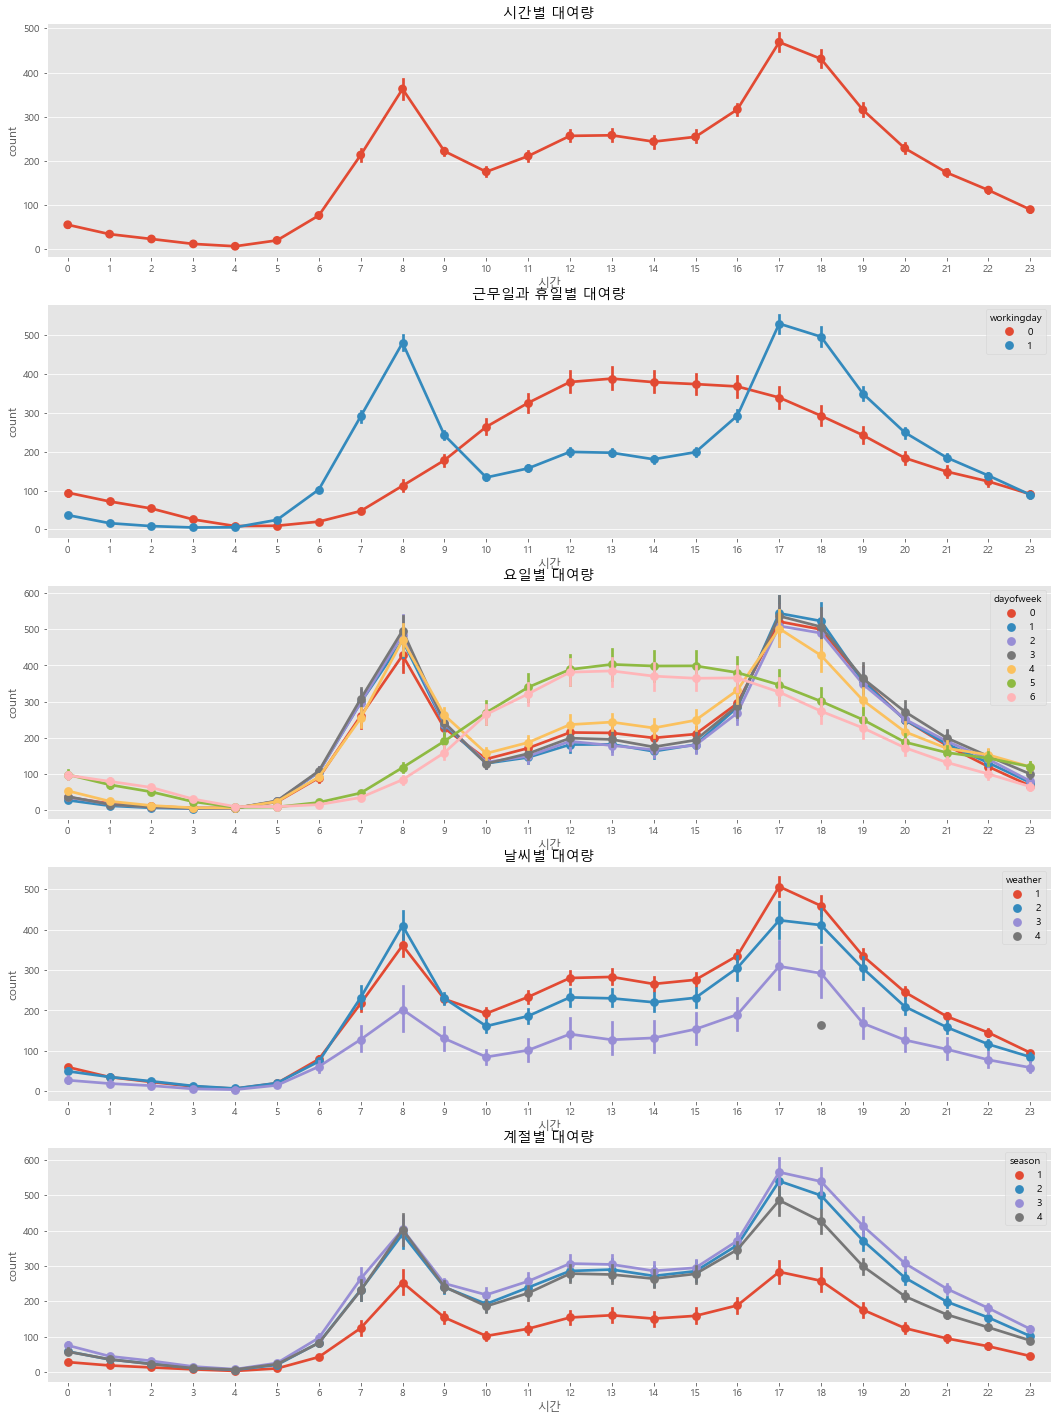

In [90]:
# 시간, 주중, 요일별 날씨, 계절별 산점도
figure, ((ax1,ax2, ax3, ax4,ax5)) = plt.subplots(nrows=5)
figure.set_size_inches(18,25)

sns.pointplot(data=train,x = 'hour', y = 'count', ax=ax1)
ax1.set(xlabel='시간', title='시간별 대여량')

sns.pointplot(data=train, x = 'hour', y = 'count', hue= 'workingday', ax=ax2)
ax2.set(xlabel='시간', title='근무일과 휴일별 대여량')

sns.pointplot(data=train, x = 'hour', y = 'count', hue= 'dayofweek', ax=ax3)
ax3.set(xlabel='시간', title='요일별 대여량')

sns.pointplot(data=train, x = 'hour', y = 'count', hue= 'weather', ax=ax4)
ax4.set(xlabel='시간', title='날씨별 대여량')

sns.pointplot(data=train, x = 'hour', y = 'count', hue= 'season', ax=ax5)
ax5.set(xlabel='시간', title='계절별 대여량')

plt.show()

In [91]:
# 요일과 관련없는 항목들의 상관계수
corrMat = train[['temp','atemp','casual','registered','humidity','windspeed','count']]
corrMat = corrMat.corr()
print(corrMat)

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


In [92]:
mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False    # array의 1의 값을 기준으로 상위부분은 출력 제외

<AxesSubplot:>

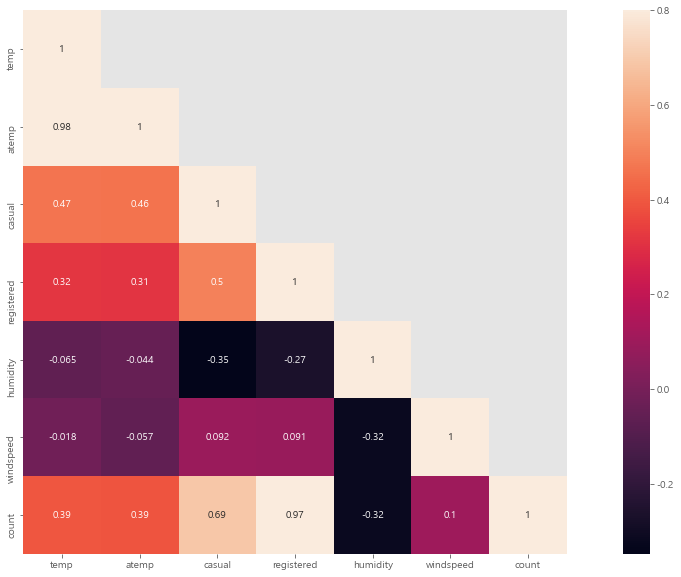

In [93]:
# 상관계수의 Heat Map
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMat, mask = mask, vmax = 0.8, square=True, annot=True)

> 온도, 습도, 풍속은 거의 연관관계가 없다.    
> 대여량과 가장 연관이 높은 것은 registered로 등록된 대여자가 많지만, test.csv에는 이 값이 없다.      
> atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도를 feature로 사용하기에는 적합하지 않을 수 있다.(공선성 위반)   

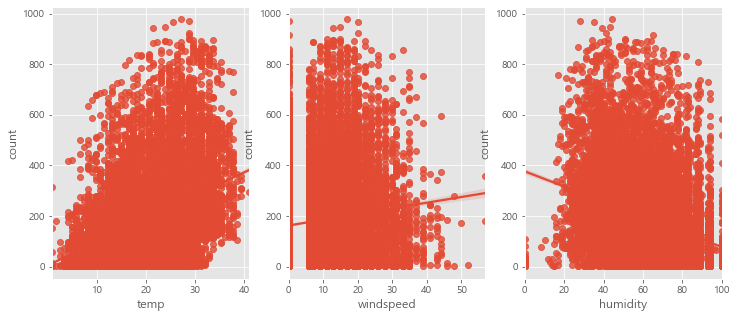

In [94]:
# 온도, 풍속, 습도에 따른 산점도
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12,5)

sns.regplot(x= 'temp',y= 'count', data=train, ax = ax1)
sns.regplot(x= 'windspeed',y= 'count', data=train, ax = ax2)
sns.regplot(x= 'humidity',y= 'count', data=train, ax = ax3)

plt.show()

> 풍속의 경우 0에 숫자가 몰려 있는 것으로 보아, 아마도 관측되지 않은 수치(결측치)에 대해 0으로 기록된 것 같다.

In [95]:
# datetime을 년도별 월별로 구분하여 컬럼 추가
def concatenate_year_month(datetime):
    return '{0}-{1}'.format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime', 'year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


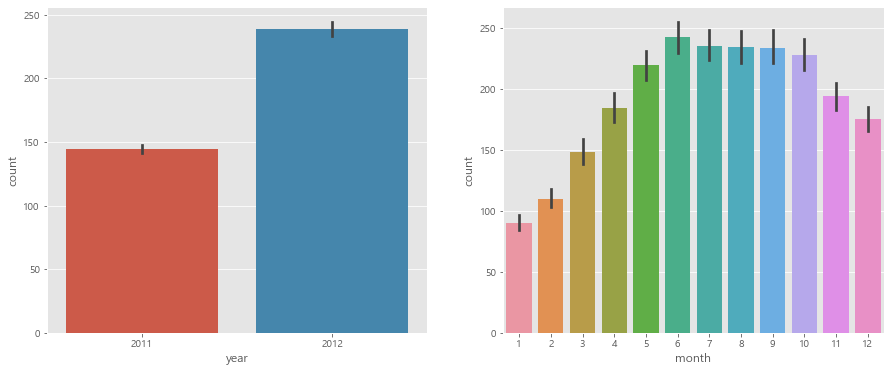

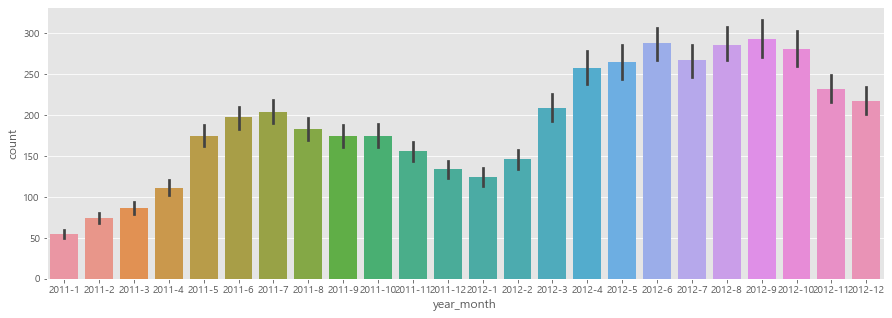

In [96]:
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,6)

sns.barplot(data=train, x='year', y='count', ax=ax1)

sns.barplot(data=train, x='month', y='count', ax=ax2)

figure, (ax3) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(15,5)
sns.barplot(data=train, x='year_month', y='count', ax=ax3)

plt.show()

> 2011년 보다 2012년의 대여량이 많다.    
> 겨울 보다는 여름에 대여량이 많다.    
> 2011년과 2012의 월별 데이터를 이어보면 전반적으로 증가하는 추세이다.

----
# Target Column의 정규분포 구성

In [97]:
# train의 count에서 low fitting과 overfitting 제거로 정규분포 구성

# 현재 크기
print(train.shape)

# 정규분포로 제거
trainWithoutOutliers = train[np.abs(train['count']-train['count'].mean()) <= (3*train['count'].std())]
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


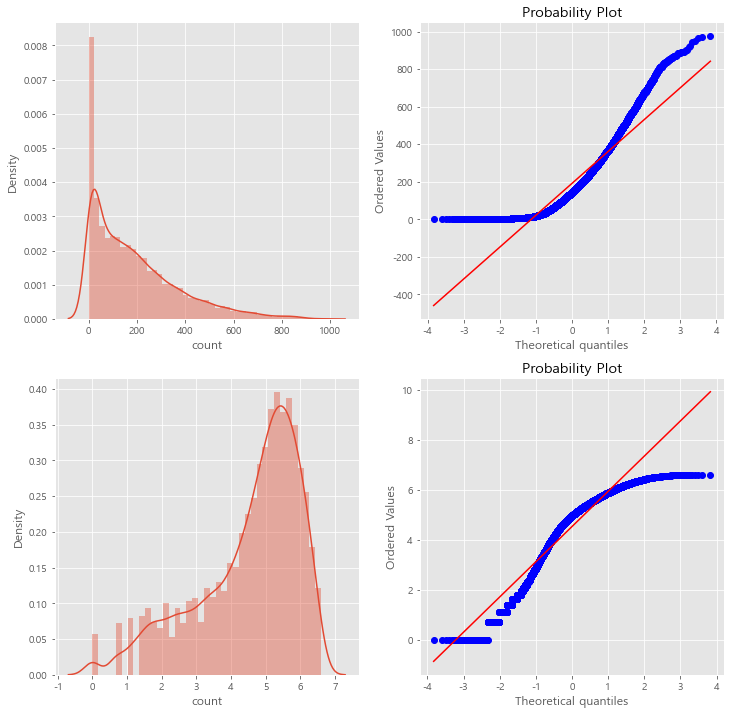

In [98]:
# count값의 데이터 분포도 파악
figure, axes = plt.subplots(ncols=2,nrows=2)
figure.set_size_inches(12,12)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit = True, plot = axes[0][1])   # 확률분포
sns.distplot(np.log(trainWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log(trainWithoutOutliers['count']), dist='norm', fit = True, plot = axes[1][1])   # 확률분포

plt.show()

> train의 count 변수는 왼쪽으로 치우쳐져 있음.    
> 대부분의 기계학습은 종속변수가 normal이어야 함으로 정규분포를 갖는 것이 바람직 하다.    
> 대안으로 이상치 데이터를 제거하고 count 컬럼에서 log를 씌워 변경해봐도   
> 정규분포를 따르지는 않지만 이전 그래프 보다는 좀 더 자세히 표현하고 있다.

In [99]:
train.shape

(10886, 20)

In [100]:
# Test data
test = pd.read_csv('./Data/bike_test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# Feature 구성

In [101]:
# Test datetime 분할
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
print(test.shape)


(6493, 16)


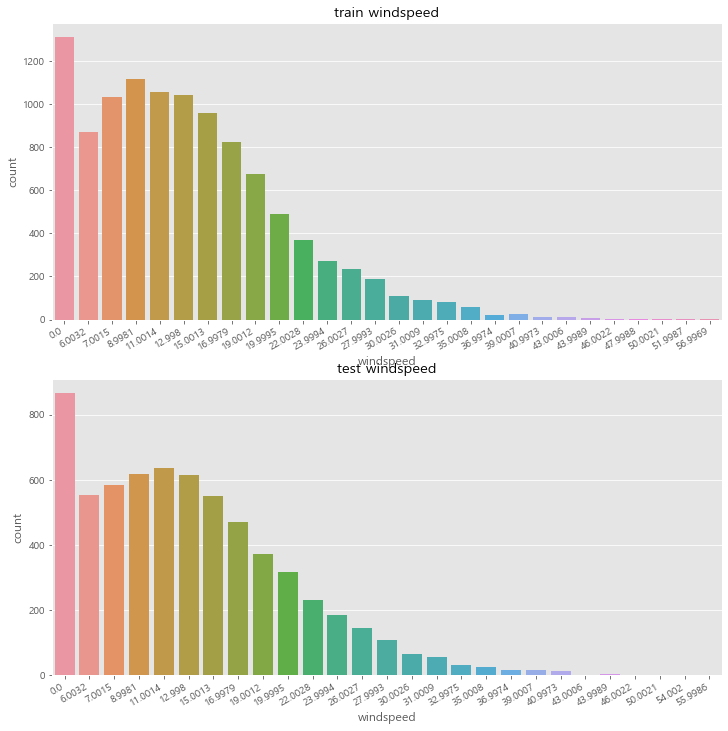

In [102]:
# windspeed와 count
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(12,12)

# train dataset 확인
plt.sca(axes[0])
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=train, x='windspeed', ax = axes[0])
# test dataset 확인
plt.sca(axes[1])
plt.xticks(rotation = 30, ha = 'right')
axes[1].set(ylabel = 'Count', title = 'test windspeed')
sns.countplot(data=test, x='windspeed', ax = axes[1])

plt.show()

### windspeed에 0 값이 제일 많다. 아마도 결측치 data를 0으로 입력한 것 같다.  

## windspeed의 0의 data를 평균값으로 대체


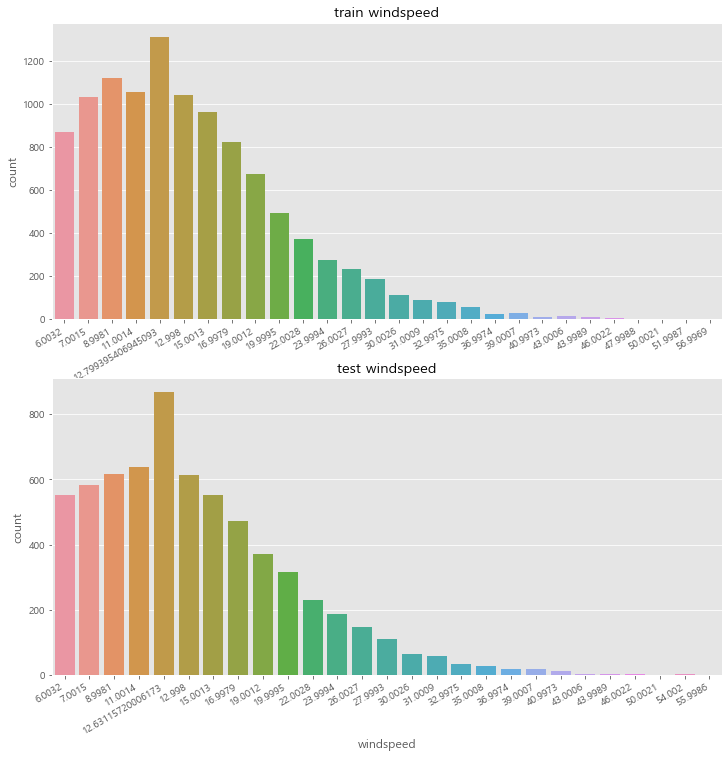

In [103]:
train_mean = train.copy()
test_mean = test.copy()

# 평균값으로 대체
train_mean.loc[train_mean['windspeed']==0, 'windspeed'] = train_mean['windspeed'].mean()
test_mean.loc[test_mean['windspeed']==0, 'windspeed'] = test_mean['windspeed'].mean()

# windspeed와 count
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(12,12)

# train dataset 확인
plt.sca(axes[0])
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=train_mean, x='windspeed', ax = axes[0])
# test dataset 확인
plt.sca(axes[1])
plt.xticks(rotation = 30, ha = 'right')
axes[1].set(ylabel = 'Count', title = 'test windspeed')
sns.countplot(data=test_mean, x='windspeed', ax = axes[1])

plt.show()

In [104]:
print(train_mean['windspeed'].describe())
print('-'*40)
print(test_mean['windspeed'].describe())

count    10886.000000
mean        14.343177
std          6.671949
min          6.003200
25%          8.998100
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64
----------------------------------------
count    6493.000000
mean       14.317776
std         6.626662
min         6.003200
25%         8.998100
50%        12.631157
75%        16.997900
max        55.998600
Name: windspeed, dtype: float64


## windspeed의 0의 data를 중앙값으로 대체


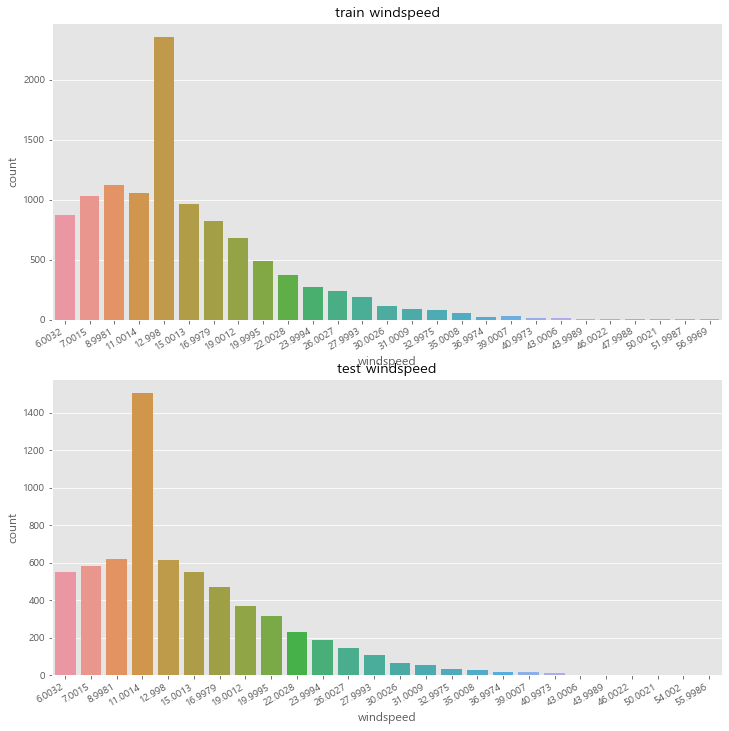

In [105]:
train_median = train.copy()
test_median = test.copy()

train_median.loc[train_median['windspeed']==0, 'windspeed'] = train_median['windspeed'].median()
test_median.loc[test_median['windspeed']==0, 'windspeed'] = test_median['windspeed'].median()

# windspeed와 count
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(12,12)

# train dataset 확인
plt.sca(axes[0])
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=train_median, x='windspeed', ax = axes[0])
# test dataset 확인
plt.sca(axes[1])
plt.xticks(rotation = 30, ha = 'right')
axes[1].set(ylabel = 'Count', title = 'test windspeed')
sns.countplot(data=test_median, x='windspeed', ax = axes[1])

plt.show()


> 쉽게 대체 할 수 있지만 0의 데이터 양이 많아서 도움이 되지 않는다.

In [106]:
# windspeed가 0인 것과 아닌 것으로 구분하여 숫자를 파악
trainWind0 = train[train['windspeed']==0]
trainWindN0 = train[train['windspeed']!=0]

print(trainWind0.shape)
print(trainWindN0.shape)
print(trainWind0.windspeed.count() / train.windspeed.count()*100, '%')

(1313, 20)
(9573, 20)
12.061363218813154 %


In [107]:
# windspeed가 0인 것과 아닌 것으로 구분하여 숫자를 파악
testWind0 = test[test['windspeed']==0]
testWindN0 = test[test['windspeed']!=0]

print(testWind0.shape)
print(testWindN0.shape)
print(testWind0.windspeed.count() / test.windspeed.count()*100, '%')

(867, 16)
(5626, 16)
13.35284152163869 %


> train data 중 windspeed가 0인 data가 12%   
> test data 중 windspeed가 0인 data가 13%를 차지함으로 단순한 평균이나 중앙값으로 대체하는 것은 도움이 되질 않는다.   
> RandomForest Regression의 Maching Learning model을 이용하자...

In [108]:
# RandomForest를 이용하여 0값을 대체
def predict_windspeed(data):
    
    # windspeed가 0인것과 아닌것으로 분리
    dataWind0 = data[data['windspeed'] == 0]
    dataWindN0 = data[data['windspeed'] != 0]
    
    # Feature 선택
    fCol=['season','weather','humidity','month','temp','year','atemp']
    
    # Regressor를 사용하면 많은 양의 데이터가 출력되어 countplot을 사용할 수 없으므로
    # windspeed가 0과 0이 아닌 data를 String으로 변환
    # RandomforestClassifier를 위해 대상 값을 문자형으로 변경하여 사용한다.
    dataWindN0['windspeed'] = dataWindN0['windspeed'].astype('str')
    
    # Random Forest
    rfModelWind = RandomForestClassifier()
    
    # fCol에 있는 항목으로 학습
    rfModelWind.fit(dataWindN0[fCol], dataWindN0['windspeed'])
    
    # windspeed가 0인 데이터의 예측
    wind0Values = rfModelWind.predict(X=dataWind0[fCol])
    
    # 예측후 사용할 dataframe 생성
    predictWind0 = dataWind0
    predictWindN0 = dataWindN0
    
    # 예측값 대입
    predictWind0['windspeed'] = wind0Values
    
    # data 합치기
    data = predictWindN0.append(predictWind0)
    
    # windspeed의 type을 float로 변환
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

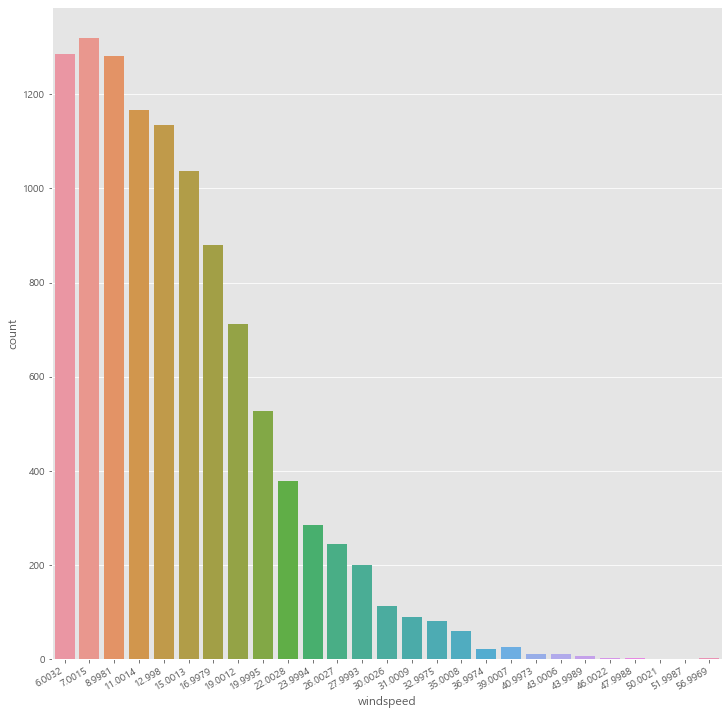

In [109]:
# train data set 중 windspeed가 0 인것을 RandomForestClassifier로 대체
train = predict_windspeed(train)

# windspeed와 count
fig, ax1 = plt.subplots()
fig.set_size_inches(12,12)

# train dataset 확인
plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=train, x='windspeed', ax = ax1)

plt.show()

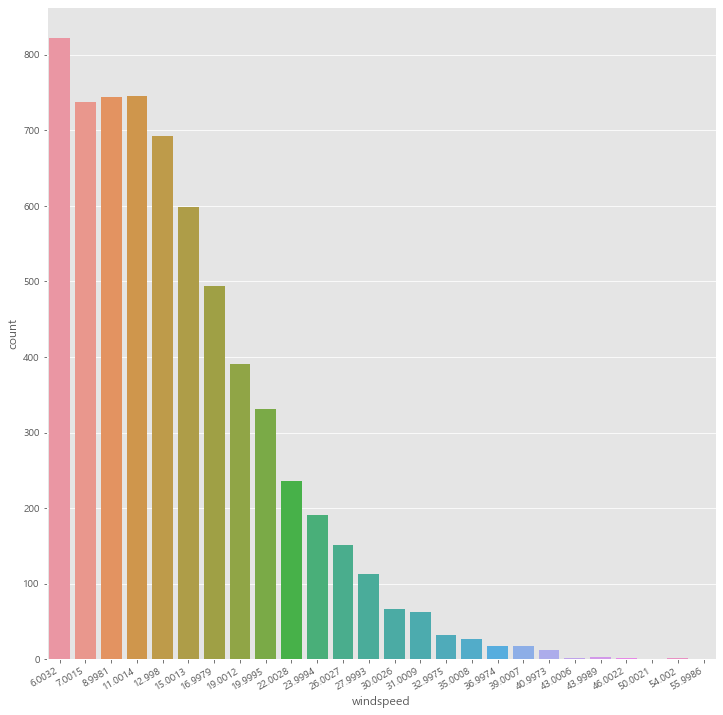

In [110]:
# test data set 중 windspeed가 0 인것을 RandomForestClassifier로 대체
test = predict_windspeed(test)

# windspeed와 count
fig, ax1 = plt.subplots()
fig.set_size_inches(12,12)

# train dataset 확인
plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data=test, x='windspeed', ax = ax1)

plt.show()

> Windspeed를 RandomForest로 값을 대입했지만 Windspeed 컬럼은 예측에 성능을 저하시키는 것 같다.


-------
# Feature Selection
- 신호와 잡음을 구분
- Feature가 많다고 무조건 좋은 성능을 발휘하는 것은 아니다.
- Feature를 하나씩 추가하고 제거하면서 성능이 좋지 않은 Feature는 제거한다.`

In [111]:
# 연속형 Feature와 범주형 Feature
# 연속형 Feature : temp, humidity, windspeed, atemp
# 범주형 Feature : season, holiday, workingday, weather, dayofweek, year, month, day, hour, minute, second

categorical_feature_name = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'year', 'month', 'day', 'hour']
for i in categorical_feature_name:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   category      
 2   holiday     6493 non-null   category      
 3   workingday  6493 non-null   category      
 4   weather     6493 non-null   category      
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
 9   year        6493 non-null   category      
 10  month       6493 non-null   category      
 11  day         6493 non-null   category      
 12  hour        6493 non-null   category      
 13  minute      6493 non-null   int64         
 14  second      6493 non-null   int64         
 15  dayofweek   6493 non-null   category      
dtypes: category(9), datetime

In [113]:
# 필요한 Feature 구성
feature_name = ['season','weather','temp','atemp','humidity','year','hour','dayofweek','holiday','workingday']
feature_name

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [114]:
X_train = train[feature_name]
print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,2011,5,5,0,0
1,1,1,15.58,19.695,76,2011,10,5,0,0
2,1,1,14.76,16.665,81,2011,11,5,0,0
3,1,1,17.22,21.210,77,2011,12,5,0,0
4,1,2,18.86,22.725,72,2011,13,5,0,0


In [115]:
X_test = test[feature_name]
print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,12.880,56,2011,3,3,0,1
2,1,1,10.66,12.880,56,2011,4,3,0,1
3,1,1,9.84,11.365,60,2011,5,3,0,1
4,1,1,9.02,10.605,60,2011,6,3,0,1


In [116]:
label_name = 'count'
Y_train = train[label_name]
print(Y_train.shape)
Y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

-----
# Grdient Boosting Regressor


In [117]:
model = GradientBoostingRegressor(n_estimators= 1000,alpha = 0.1,random_state=0)   
# Y_Train(count) data를 표준화
Y_train_log = np.log1p(Y_train)

## Training

In [118]:
model.fit(X_train,Y_train_log)

GradientBoostingRegressor(alpha=0.1, n_estimators=1000, random_state=0)

In [119]:
# 예측
pre = model.predict(X_test)
print(pre.shape)
pre[0:10]

(6493,)


array([2.36619318, 0.90360723, 0.828905  , 2.15665847, 3.52901272,
       4.46320765, 5.31055978, 4.66934243, 4.03692196, 4.13733268])

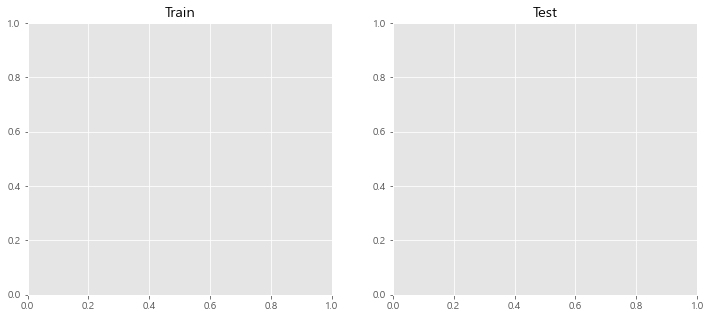

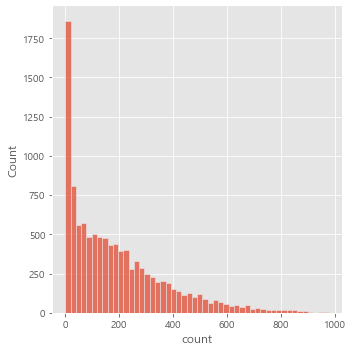

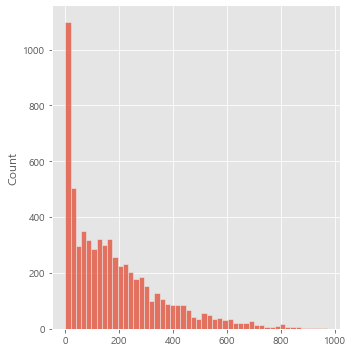

In [120]:
# 예측한 데이터를 시각화 
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.displot(Y_train, ax = axes[0], bins=50)
axes[0].set(title = 'Train')

sns.displot(np.exp(pre), ax = axes[1], bins=50)
axes[1].set(title = 'Test')

plt.show()

# Submission

In [121]:
submission = pd.read_csv('./Data/sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [122]:
submission['count'] = np.exp(pre)
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,10.656747
1,2011-01-20 01:00:00,2.468491
2,2011-01-20 02:00:00,2.290809
3,2011-01-20 03:00:00,8.642211
4,2011-01-20 04:00:00,34.090294


In [123]:
submission.to_csv('./Data/Score_02_submission.csv', index = False)

# 결론

- 범주형 Feature를 Category로 변경    
- featurep_name = ['season','weather','temp','atemp','humidity','year','hour','dayofweek','holiday','workingday']    
- GradientBoostingRegressor을 사용   
- Y_train을 표준화

> 0.37948   
> 105 / 3242   (0.03%)

----
# RMSLE(Root Mean Squared Logarithmic Error)
- 오차를 제곱해서 평균한 값의 제곱으로 값이 작을수록 정밀도가 높다.
- 0에 가까운 값이 나올 수록 정밀도가 높은 값이다.


In [124]:
from sklearn.metrics import make_scorer

In [125]:
def rmsle(predicted_values, actual_values):
    # Numpy로 배열 형태로 변경
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 log을 씌운다
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산된 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 구한다.
    mean_difference = difference.mean()
    
    # 루트를 씌운다
    score = np.sqrt(mean_difference)
    
    return score

In [126]:
rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# 교차 검증
: training data와 test data의 범위를 변경하여 교차검증을 실시

In [127]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle= True, random_state=0)  # 전체 데이터의 10등분

In [128]:
%time score = cross_val_score(model,X_train,Y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print('Score = ',round(score,5))

Wall time: 52.6 s
Score =  nan
